# Functions to Evaluate Recommendation Models
Functionalized code such that different content models are imported as modules and then standard evaluation functions are called and the results are saved to a text file.   
The following markdown describes the various parameters that must be set depending on the model being evaluated 

- 5 metrics: personalization, precision & recall @K, personal diversity, global diversity, average rating 
- For all metrics, calculate on a random subset of users and take average value. For personalization, take average across k sets (folds) of random users because comparing users to each other.    
- Set seeds such that evaluate different models on the same set of users 
- Record results from each model in a text file to compare

## Evaluation Metrics
Described more thoroughly with visualizations of matrix multiplication in Methodological Appendix
- Personalization: maximize differences between move recommendations for different people
    - Want recommendations that are actually personalized to the person    
    - K fold cross-validation across several sets of users
- Precision, Recall @ K
    - Generate recommendations based on training data. See if get movies from the test data that the user actually liked    
    - Evaluating on train/test split because do not have real time user feedback, which is ideal.      
    - Very hard to get good scores because if rated 100 movies but there are 10,000 movies in the catelog, unlikely that you will recommended one of those 100 movies in the top K. Doesn't mean bad recommendations. 
- Personal Diversity
    - Content models tend to create overspecialization where users are only presented with one type of movie. Thus need to evaluate the degree of this problem. Ideally would provide some variety.   
    - Filtering function in UI also helps deal with this problem as users can view specific types of recommendations 
- Average Rating
    - Want to recommend "good" movies with high average ratings. Recommendation system is not specifically designed for this, but good to track across systems   
    - Generate recommendations for random users
    - Merge in average ratings of the recommended movies
    - Take average of average ratings 
    - Take average across random sample of users
- Global diversity 
    - Want to recommend some "unpopular" movies such that users view movies in the long tail that they otherwise would not be exposed to
    - Generate recommendations for random  users
    - Merge in count of number of reviews for the recommended movies
    - Take the minimum count (extent of the long tail)
    - Average minimum counts across random users

## Flow of Model Building/Testing
1. Content models with different combinations of metadata
2. Combined content models where some subset of movies are evaluated using one model and another subset with another
    - Best result is used for item-item recommendations in UI
3. Combined collaborative filtering and content models where some subset of movies are evaluated with collaborative filtering and another subset with a content model 
    - Best result is used for personalized recommendations in UI

## How To: Import Recommendation System

1)  Convert recommendation system notebook to .py

2) Import function using:

from <name.py> import <name of the recomendation function>
    
example: from contentbasedrecommendationsystem import user_content_recommendations
    
3) recommendation_system: give the name of the recommendation system, you want to get the evaluations for   
    
    
## How to: Run different types of models
- Individual model with full data:
    - df1 = sparse dataset
    - cols1 = columns from df1
    - movieIds = moviesIds (row names) from df1
    - keep_movies = movieIds  
    - keep_movies1 = []
    - keep_movies2 = []
    - df2 = False, cols2 = False, recommendation_system_input = False
    - recommendation_system = content_based_recommendations.user_content_recommendations
- Individual model with specific subsets of movies:
    - keep_movies = subset of movies (likely either movieIds_tags or movieIds_notags)
        - Evaluate on subset
    - keep_movies1 = same subset 
        - Generate recommendations only from subset
    - Else same
- Combined model with two different input datasets
    - df1 = sparse dataset1 , df2 = sparse dataset2
    - cols1 = columns from df1, col2 = columns from df2
    - keep_movies = movieIds  (evaluate on all movies)
    - keep_movies1 = subset 1
    - keep_movies2 = subset 2
    - keep_movies = movieIds (row names) from df1 or df2 -- identical 
    - recommendation_system_input = content_based_recommendations.user_content_recommendations
    - recommendation_system = content_based_recommendations_combine.content_models_combine
       
list_user parameter: unique list of users to randomly sample from. For most models, based on users in ratings df. But for collaborative filtering, predictions are pre-computed on a subset of qualifying users (> 20 ratings), so limit based on df2 (which in that case are collaberative filtering set)

# Result Summary

### Content Systems: One Model
- content_initial_eval (processed_df_sparse): genre, actor, director. Cosine similarity between movies
- __Baseline__: contentv2_noMovieNorm_eval (processed_df_sparse): same data, but no normalization of movie vector (true for all others)
- __Description TFIDF__: content_desc_eval (processed_df_desc): top 5 TF-IDF tokens from movie description
    - Add Genre tokens: content_desc_genre_eval (processed_df_desc_genre_sparse): description tokens and genre
- __All meta-data__: content_all_meta_eval (processed_df_all_meta_sparse): genre, actor, director, decade, country, production company 
    - Try also with each individual feature in the "all" version: content_ (genre, actors_directors, decade, country, production) _eval
    - content_baseline_plus_prod_eval: genre, actors, director, production company 
        - country and decade individually perform poorly individually
- __Tags TFIDF__: content_tags_eval (processed_df_tags_sparse): top 5 TF-IDF genome tags
- __Tags Relevant__: content_tags_rel_eval (processed_df_tags_rel_sparse): top 5 genome tags by relevance score
    - __Tags Relevant + Baseline__: content_baseline_tags_rel_eval (processe_df_baseline_tags_rel_sparse): top 5 tags by relevance + baseline features. Attempt to overcome long tail problem
    - __Text TFIDF__: content_text_eval (processed_df_text_sparse): top 5 TF-IDF text field (tags + description). Attempt to overcome long tail problem.

| Model | Personalization | Precision@10 | Recall@10 | Personal diversity | Global diversity | Average rating
| --- | --- | --- | --- | --- | --- | --- 
| Baseline | 0.99 | 0.02 | 0.007 | 0.52 | 6.4 | 3.2
| All meta-data | 0.99 | 0.02 | 0.006 | 0.42 | 1.05 | 3
| Description TFIDF | 0.99 | 0 | 0 | 0.62 | 1.1 | 3.1
| Tags TFIDF | 0.96 | 0.075 | 0.02 | 0.36 | 415 | 3.8
| Tags Relevant | 0.98 | 0.06 | 0.02 | 0.60 | 524 | 3.5
| Text TFIDF | 0.96 | 0.085 | 0.02 | 0.32 | 647 | 3.8
| Tags Relevant + Baseline | 0.99 | 0.045 | 0.02 | 0.64 | 116 | 3.4


- Baseline (genre, actor, director): best set of metadata 
    - Adding in combinations of country, decade, and production company worsen performance -- unimportant features to people's opinions of a movie
    - Actors and directors important to include with genre, else no differentiation between movies that have the same genre list
- Description tokens perform poorly (precision, recall 0)
- Genome tagging performs well in terms of performance (precision, recall) and for personalization, personal diversity,  average rating
    - However, worse for global diversity because 75% of movies do not have tagging, and tags heavily biased towards movies with many ratings.
    - Top 5 relevant genome tags better than top 5 tf-idf tags in personal diversity. Tags TFIDF better (slightly) in precision, recall, average rating
    - Tags capture most important information from other meta-data because include info about most important actors, genres, plot themes
- Combining tags with other metadata to increase coverage (baseline metadata, description tokens) worsens performance
    - Metadata: assuming these movies don't have info related to that tag. Not a valid assumption, just not labeled
    - Description: still not recommending tail even though have description for those. However, for the more popular movies, adding description into the text tfidf does seem to improve performance
    
    
Based on the above, overall conclusion is that genome tagging based on relevance does the best in performance but poor global diversity. Prompted following design: Two separate models for movies with tags and movies without tags. Half recommendations from one, half from the other 
- Performance and credibility from tag model among popular movies
    - Also, people tend to expect recognizable movies in their recommendations so lends to credibilty of system. Preps them to be accepting of the long tail that will increase our overall streaming
- Access to long tail for baseline model among untagged, less popular movies       
--> exploration and exploitation

### Content Systems: Two Models       
(1) Evaluate models on relevant dataset     
- __Relevant Tags Only__: content_tags_rel_only_eval (processed_df_tags_rel_sparse + keep_cols = movieIds_tags): top 5 genome tags by relevance score ONLY with movies that have tags
- __TFIDF Tags Only__: content_tags_only_eval (processed_df_tags_sparse + keep_cols = movieIds_tags): top 5 genome tags by tfidf ONLY with movies that have tags
- __TFIDF Text Tags Only__: content_text_tagsonly_eval (processed_df_text_sparse + keep_cols = movieIds_tags): top 5 tags+description fields by tfidf ONLY with movies that have tags
- __Baseline no tags__: content_baseline_notags_eval (processed_df_sparse + keep_cols = movieIds_notags): basline model (genre, actor, director) only for movies without tags (long tail) 

(2) Evaluate combined models on full dataset   
- __Combined Relevant__: content_twomodels_tags_rel_eval: combination of __Baseline no tags__ and __TFIDF Tags Only__ models using content_based_recommendations_combine system. df1 = baseline no tags, df2 = tags (tfidf) tags
- __Combined TFIDF__: content_twomodels_tags_eval: combination of prior __Baseline no tags__ and __TFIDF Tags Only__ models using content_based_recommendations_combine system. df1 = baseline no tags, df2 = tags (relevant) tags
- __Combined Text__: content_twomodels_text_eval: combination of prior __Baseline no tags__ and __TFIDF Text Only__ models using content_based_recommendations_combine system. df1 = baseline no tags, df2 = text (tfidf) tags

| Model | Personalization | Precision@10 | Recall@10 | Personal diversity | Global diversity | Average rating
| --- | --- | --- | --- | --- | --- | --- 
| Relevant Tags Only | 0.98 | 0.03 | 0.007 | 0.59 | 356 | 3.5
| TFIDF Tags Only | 0.96 | 0.07 | 0.008 | 0.36 | 910 | 3.8
| TFIDF Text Tags Only | 0.95 | 0.075 | 0.02 | 0.31 | 688 | 3.8
| Basline no tags | 0.99 | 0.01 | 0.005 | 0.49 | 1.2 | 3.0
| Combined Relevant | 0.99 | 0.025 | 0.01 | 0.67 | 1.85 | 3.25
| Combined TFIDF | 0.99 | 0.045 | 0.01 | 0.70 | 1.85 | 3.39
| Combined Text | 0.98 | 0.055 | 0.015 | 0.69 | 1.85 | 3.42

- Genome tagging for movies only with tags: Almost identical evaluations to full data, which makes sense as even with full data effectively just ignored movies without tags. 
    - Worse recall = likely artifact of different sample users chosen since different universe. These users happened to have rated more movies positively, thus creating a larger denominator for recall. but precision still performing well. 
    - TFIDF Text is the best on just tags sample 
- Baseline for movies without tags: compared to full data, slightly worse performance in all stats. To be expected since only evaluating on long tail movies. For example, if rarely viewed then low likelihood that they are in the user's test set for precision, recall 
- Combined: performance in between two individual models. Higher personal diversity (evaluated on baseline characteristics because available for all movies)
    - Better than any single models that consider all movies 
    
__Best Content Model:__ Combined Text

### Collaborative Filtering, Content Combined Model
- Cannot evaluate precision and recall for the combined model because collaborative filtering predictions are pre-computed. However, we know precision and recall for this model on its own test and train set and it is significantly superior to any content model
- Instead evaluate all the other metrics on combined AND evaluate content model(s) on the remainder of the movies not included in collaborative filtering
- Collab filtering is only evaluated on movies with more than 50 ratings and a subset of users out of users that have given at least 20 users. Thus all other movie recommendations will be generated from a content model 

(1) Which content model(s) to use on movies not included in collab filtering?
- __Baseline__: content_baseline_nocollab_eval. Baseline content model on movies not included in collaborative filtering predictions
    - keep_movies = set(movieIds).difference(set(collab_predictions.movieId.unique())) 
    - keep_movies1 = set(movieIds).difference(set(collab_predictions.movieId.unique())) 
- __Combined Text__: (baseline no tags + TFIDF text tags)  content_combined_tags_nocollab_eval. Combined text model on movies not included in collaborative filtering - further break down into movies with and without tags
    - keep_movies = set(movieIds).difference(set(collab_predictions.movieId.unique())) 
    - keep_movies1 = set(movieIds_notags).difference(set(collab_predictions.movieId.unique())) 
    - keep_movies2 = set(movieIds_tags).difference(set(collab_predictions.movieId.unique())) 
    
(2) Combined collaborative + (best) content model from above
- __Combined Collaborative+Content__: collab_content_combined. Baseline content model + collaborative filtering model. Content recommendations for any movies that don't have a collaborative prediction for each individual user.  
    - df2 = collab_predictions.copy()
    - keep_movies1, keep_movies2 = []
    - recommendation_system_input = content_based_recommendations.user_content_recommendations
    - recommendation_system = collab_content_recommendations_combine.collab_content_combine
    - list_user = set(df2.userId) -- __New Parameter__. Collab filtering is pre-computed for a limited set of users, so limit to these users only. All others have list_user = set(ratings.userId) 

| Model | Personalization | Precision@10 | Recall@10 | Personal diversity | Global diversity | Average rating
| --- | --- | --- | --- | --- | --- | --- 
| Baseline | 0.99 | 0.01 | 0.005 | 0.54 | 2.3 | 3.1 
| Combined Text | 0.91 | 0.005 | 0.0003 | 0.75 | 2.95 | 3.3 
| Combined Collaborative+Content | 0.87 | - | - | 0.75 | 6.95 | 3.3

- Baseline performs better than combined text for the non-collaborative filtering movies for precision, recall.
    - Makes sense because there are a small number of movies not in collab filtering with tags since tags are biased towards popular movies. We are then forcing half of our recommendations to be from this small subset, where it is unlikely that is a "relevant" movie
- Combined collaborative + content performs similarly to best combined content model for all non-precision, recall metrics except personalization. Does better in personal diversity. Personalizations is still high despite decrease. We know precision and recall are better for this model, so definitely a superior model.


__Best Personalization Model:__ Combined Collaborative + Content

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
import operator
import scipy.spatial.distance as distance
from sklearn import metrics 
import random
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import fastparquet
import pickle
import scipy
import sklearn
import content_based_recommendations
import content_based_recommendations_combine
import collab_content_recommendations_combine

## Load Data

In [2]:
# ratings and movie ratings aggregation data
ratings = pd.read_parquet('ratings_sample.parq')
ratings = ratings.reset_index()
movies_ratings = pd.read_parquet('movies_ratings.parq')
movies_ratings = movies_ratings.rename(columns={"avg": "Average_Ratings"})
movies_ratings['weighted_avg'] = movies_ratings.cnt * movies_ratings.Average_Ratings

In [3]:
# specify sparse matricies of features to use for content attributes 
df1 = scipy.sparse.load_npz("processed_df_sparse.npz")
df2 = scipy.sparse.load_npz("processed_df_text_sparse.npz")
#df2 = False

# preloaded collaborative filtering predictions
collab_predictions = pd.read_parquet('Predictions/KNN_predictions_df.parq')
collab_predictions = collab_predictions.rename(columns = {'est':'prediction', 'uid':'userId', 'iid':'movieId'})
collab_predictions = collab_predictions.drop(columns = ['r_ui', 'details.actual_k', 'details.was_impossible'])
df2 = collab_predictions.copy()

with open('sparse_metadata', "rb") as f:
    cols1 = pickle.load(f)
    movieIds = pickle.load(f)
    
with open('sparse_metadata_text', "rb") as f:
    cols2 = pickle.load(f)
    movieIds = pickle.load(f)
#cols2 = False

In [4]:
# load movieId lists for movies with and without tags so can specify which movies to keep for which models
with open('movieIds_tags', "rb") as f:
    movieIds_tags = pickle.load(f)
with open('movieIds_notags', "rb") as f:
    movieIds_notags = pickle.load(f)

In [5]:
# specify which movies we want to keep for evaluation and for generating recommendations 
keep_movies = movieIds # evaluate against
keep_movies1 = [] # generate recs from model 1 (df1) - if [] then all movies
keep_movies2 = [] # generate recs from model 2 (df2) - if [] then all movies 

In [6]:
#list_user = set(ratings.userId)
# if collaborative filtering - content combo:
list_user = set(df2.userId)

In [7]:
# use to get a subset of columns from processed_df_all_meta_sparse
#index = [cols.index(i) for i in cols if i.startswith('production') | i.startswith('genres') | i.startswith('actors') |
#        i.startswith('director')]
#df = df[:, index]
#cols = [cols[i] for i in index]

## Define Parameters
- n = # number of users
- top_n = # top recommendations

In [8]:
n = 20
top_n = 10

## Helper Fns

In [9]:
# get top n recommendations with movieIds
def user_movie_id(movies,n):
    return movies['movieId'][:n]

# get top n recommendations with average raitngs
def user_avg_rating(movies,n):
    return movies['Average_Ratings'][:n]

## Specify recommendation system

In [10]:
recommendation_system_input = content_based_recommendations.user_content_recommendations
#recommendation_system = content_based_recommendations_combine.content_models_combine
recommendation_system = collab_content_recommendations_combine.collab_content_combine

#recommendation_system_input = False
#recommendation_system = content_based_recommendations.user_content_recommendations

## Open file to record evaluations

In [11]:
f = open("evaluations/collab_content_combined.txt", "w")

# Personalization 
How different are recommendations for different users? Are our recomendations actually personalized?    
     
K fold cross-validation across several sets of users
- Generate recommendations for n users
- Create movie matrix with row = user, column = movie, value = 1/0 for if movie recommended
- Cosine similarity between users. Average of elements above the diagonal
- Repeat for k folds and take overall average

In [12]:
# return user predictions for each user in users_list
# return list of all predictions for users in user_list
def get_users_prediction(users_list,top_n,users_prediction,recommendation_system, df1, ratings, movieIds, movies_ratings,
                         keep_movies1, df2 = False, keep_movies2 = False, recommendation_system_input = False):
    for i in users_list:
        # generate recommendations 
        recommendation = recommendation_system(i, df1, ratings, movieIds, movies_ratings, keep_movies1, 
                                               df2, keep_movies2, recommendation_system_input)
        # top_n recommendations
        prediction = user_movie_id(recommendation,top_n).astype(int).values
        # append to list of predictions
        users_prediction = users_prediction.append(pd.Series(prediction),ignore_index=True)
        
    return users_prediction

# generate movie matrix: 
# row = user; column = movie ; value = 0 movie not recommended, 1 movie recommended
def user_matrix(users_pred):
    data_melt= pd.DataFrame(data=users_pred).reset_index().melt(id_vars='index', value_name='movieId',)
    data_melt = data_melt[['index', 'movieId']].pivot(index='index', columns='movieId', values='movieId')
    cols = data_melt.columns
    
    # replace na with 0
    for i in cols:
        data_melt[i] = np.where(data_melt[i].isna(), 0, 1)
        
    return data_melt

# generating cosine similarity between the users. Same movie recommended for multiple users? 
# then getting the indicies of elements above diagonal (giving diagonal offsert =1 in triu_indices)
# calculating the avg of the element above diagonal 
# Personalization means 1 - similarity
# higher the personalization score, better the recommendation system in recommending personalized movies (minimize similarity)
def personalization(users_matrix,n):
   
    # cosine similiarity
    users_sim = metrics.pairwise.cosine_similarity(users_matrix)
    
    # upper triangle
    iu1 = np.triu_indices(n,k=1)
    
    # average in upper 
    similarity_avg = np.mean(users_sim[iu1])
    
    # 1 - similarity. Want to maximize score (minimize similarity)
    personalization_score = 1 - similarity_avg

    return personalization_score


# evaluate personalization on k random folds. Mean. 
def cross_fold_eval(unique_users,recommendation_system, movies_ratings, df1, keep_movies1, 
                    df2 = False, keep_movies2 = False, recommendation_system_input = False, 
                    k_fold=10,n=10,top_n=10):
    
    # initiate to sum scores across folds (take average at end)
    kfold_personalization=0
    
    # look through k folds
    for i in range(k_fold):
        
        # generate list of n random users
        users_list = random.sample(unique_users, n)
        
        # columns: top_n recommendations
        # users_prediction:  top_n recommendations for n users. 
        column_names = list(range(top_n))
        users_prediction = pd.DataFrame(columns = column_names)
                
        # getting predictions for all sampled users
        users_pred = get_users_prediction(users_list,top_n,users_prediction,recommendation_system, 
                                          df1, ratings, movieIds, movies_ratings, keep_movies1,
                                          df2 = df2, keep_movies2 = keep_movies2, 
                                          recommendation_system_input = recommendation_system_input)
        
        # getting user by movies matrix with binary indicators 0: movie not recommended, 1: movie got recommended
        users_matrix = user_matrix(users_pred)
        
        # find personalization score based on movie matrix. Sum across folds 
        kfold_personalization+=personalization(users_matrix,n)
        
        
    # average across all folds
    kfold_eval = kfold_personalization/k_fold
    
    # write to file 
    print(f'Personalization score for {k_fold} folds across {n} users for top {top_n} recommendations: {kfold_eval}', file = f)

In [13]:
# get unique user set 
# K-fold cross validation for personalization score 
cross_fold_eval(list_user,recommendation_system, movies_ratings, df1, keep_movies1, df2 = df2, keep_movies2 = keep_movies2, 
                recommendation_system_input = recommendation_system_input, n = n, top_n = top_n)

# Precision and Recall 
- Generate train/test split among users that have at least 20 rated target movies
- Generate recommendations on train, see if got any "correct" from test. Calculate precision, recall
- Average across users

### Random samples of users who have rated minimum of 20 movies OUT OF target movies (keep_movies)
Need enough movie ratings to do a reasonable train/test split. 
- keep_movies: universe of movie we want to calculate precision and recall in 
- n_users: Number of users to filter the from the dataset

In [14]:
def target_users(ratings, keep_movies, list_user, n_users = 1000):
    
    # keep users with at least 20 ratings out of target movies (keep_movies)
    users_list = ratings[(ratings.movieId.isin(keep_movies)) & (ratings.userId.isin(list_user))
                        ].groupby('userId')['userId'].count().reset_index(name="rating_count")
    users_list = set(users_list[users_list['rating_count']>=20]['userId'].values)
    print(f' Number of users who rated at least 20 movies: {len(users_list)}')
    
    # random sample of n_users 
    random.seed(42)
    random_users = random.sample(users_list, n_users)
    # get the ratings of the random sample of users
    users_ratings = ratings[ratings.userId.isin(random_users)]
    
    return users_ratings, random_users

users_ratings, random_users_20 = target_users(ratings, keep_movies, list_user)

 Number of users who rated at least 20 movies: 1000


### train/test split - Keeping the users distribution similar
Select subset of users and then split each user's ratings into train/test

In [15]:
def train_test_split(random_users, users_ratings):
    
    # creating train/test empty dataframe
    train = pd.DataFrame(columns=['index','userId', 'movieId', 'rating','timestamp'])
    test = pd.DataFrame(columns=['index','userId', 'movieId', 'rating','timestamp'])

    # spliting each user data equally in train test
    for i in random_users:
        
        #getting individual user index in the users_ratings list
        random_index =set(users_ratings[users_ratings['userId'] == i].index.values)

        # dividing the user ratings count/2
        n_len = np.math.floor(len(random_index)/2)

        # getting index for train data: random half of that user's ratings
        train_ind = set(random.sample(random_index, n_len))

        # getting index for test data by removing train index from all index for that user
        test_ind = set(random_index-train_ind)

        # assign indexes to train, test set
        df_train = users_ratings.loc[train_ind]
        df_test = users_ratings.loc[test_ind]
        
        # appending that user data to train/test df
        train = train.append(df_train)
        test = test.append(df_test)
        
    return train, test

train, test = train_test_split(random_users_20, users_ratings)

### Calculate Average Precision, Recall across random users
- Generate recommendations based on training data. See if get movies from the test data that the user actually liked
- Relevant item: Has in test with rating >= 2 
    - Generous definition of relevant because hard to get precision, recall without user feedback. 
    - Limit to movies in keep_movies set. Only movies possibly being generated by model
- Precision@k = (# of recommended items @k that are relevant) / (# of recommended items @k)
- Recall@k = (# of recommended items @k that are relevant) / (total # of relevant items)   

In [16]:
# precision@K = (# of recommended items @k that are relevant) / (# of recommended items @k)
def calc_precision_k(recommended_relevant_count,recommended_count):
    precision_k = recommended_relevant_count/recommended_count
    return precision_k

# Recall@k = (# of recommended items @k that are relevant) / (total # of relevant items)   
def calc_recall_k(recommended_relevant_count,relevant_count):
    if relevant_count==0:
        return 0
    else:
        recall_k = recommended_relevant_count/relevant_count
        return recall_k
    
# average precision and recall across random users
def avg_precision_recall(random_userId, keep_movies, movies_ratings, df1, keep_movies1, df2 = False, keep_movies2 = False, 
                         recommendation_system_input = False, top_n = 10, k = 5):
    
    # lists to record
    avg_precision=[]
    avg_recall =[]
    tot_rec_rel = []
    
    # look through user subset
    for i in random_userId:
        
        # generate recommendations 
        recommendation = recommendation_system(i, df1, train, movieIds, movies_ratings, keep_movies1,
                                               df2, keep_movies2, recommendation_system_input)
        # getting the recommended movies @k
        recommended_movies = set(recommendation[:k].movieId)

        # number of recommended movie @k
        recommended_count = k
        
        # getting relevant movies, where ratings >= 2
        # limit to keep movies as these are the only movies being possibly produced by the recommendation system 
        relevant_movies =set(test[(test.movieId.isin(keep_movies)) &
                                  (test['userId']==i) & (test['rating']>=2) ]['movieId'].values)
        # Total number of relevant movie
        relevant_count = len(relevant_movies)
        
        # Getting movies that are relevant and recommended (set intersection)
        recommended_relevant_movies = recommended_movies.intersection(relevant_movies)
        
        # number of relevant recommended movies
        recommended_relevant_count = len(recommended_relevant_movies)
        
        # calculate precision, recall
        precision_k = calc_precision_k(recommended_relevant_count,recommended_count)
        recall_k = calc_recall_k(recommended_relevant_count,relevant_count)
        
        # record 
        avg_precision.append(precision_k)
        avg_recall.append(recall_k)
        tot_rec_rel.append(recommended_relevant_count) # absoute number of recommended relevant movies 
        
    # take average across n users 
    precision_avg = np.mean(avg_precision)
    recall_avg = np.mean(avg_recall)
    rec_rel_avg = np.mean(tot_rec_rel)

    return precision_avg, recall_avg, rec_rel_avg

In [17]:
# out of elligible users, get random subset of n from training data (same users as in test data)

random.seed(42)
train_user_id = set(train.userId.values)
random_userId = random.sample(train_user_id, n)
random_userId[0]

130332

__Evaluate at several values of K__    
Most informative is k = 10 because generally generating 10 recommendations for display

In [18]:
k = 5
precision_k,recall_k, rec_rel_avg = avg_precision_recall(random_userId, keep_movies, movies_ratings, 
                                                         df1, keep_movies1, df2, keep_movies2, 
                                                         recommendation_system_input, top_n, k)

print(f'Avg Precision at {k} for {n} users: {precision_k}', file = f)
print(f'Avg Recall at {k} for {n} users: {recall_k}', file = f)
print(f'Avg Number of relevant recommendations at {k} for {n} users: {rec_rel_avg}', file = f)

In [19]:
k = 10
precision_k,recall_k, rec_rel_avg = avg_precision_recall(random_userId, keep_movies, movies_ratings,
                                                         df1, keep_movies1, df2, keep_movies2, 
                                                         recommendation_system_input, top_n, k)
print(f'Avg Precision at {k} for {n} users: {precision_k}', file = f)
print(f'Avg Recall at {k} for {n} users: {recall_k}', file = f)
print(f'Avg Number of relevant recommendations at {k} for {n} users: {rec_rel_avg}', file = f)

In [20]:
k = 30
precision_k,recall_k, rec_rel_avg = avg_precision_recall(random_userId, keep_movies, movies_ratings,
                                                         df1, keep_movies1, df2, keep_movies2, 
                                                         recommendation_system_input, top_n, k)
print(f'Avg Precision at {k} for {n} users: {precision_k}', file = f)
print(f'Avg Recall at {k} for {n} users: {recall_k}', file = f)
print(f'Avg Number of relevant recommendations at {k} for {n} users: {rec_rel_avg}', file = f)

# Personal Diversity
How different are the movies that we are recommending to users? Content models tend to "profile" people and result in over-specialization where only provide one kind of recommendation. Ideally would provide some variety.   
- Generate recommendations for random user 
- Get "profile" of each recommended movie (non zero features)
- Find cosine similarity between recommended movies. Transform to distance so maximize
- Average over n users


__NOTE:__ movies are compared based on the features in the current model. ie if model based on tags features, then looking at diversity of tags. If model based on genres and actors, then looking at diversity of actors and genres.   
- For combined models, diversity based off of baseline features in df1 (genre, actors, directors) so that all movies equally comparable


In [21]:
def personal_diversity(top_n, rand_user, movies_ratings, df1, df2, keep_movies1, keep_movies2, 
                       recommendation_system_input, cols1):

    length = len(rand_user)
    
    # storing diversity for n users
    diversity =[]
    # find diversity for each user
    for u in range(length):
        
        # getting recommended movies
        recommendation = recommendation_system(rand_user[u], df1, ratings, movieIds, movies_ratings, keep_movies1,
                                               df2, keep_movies2, recommendation_system_input)
        
        # get top_n recommended movies 
        prediction = user_movie_id(recommendation,top_n).astype(int).values
        predicted_index = [movieIds.index(i) for i in prediction] 
        user_df = df1[predicted_index, :]
        user_movie_features = pd.DataFrame()
        
        # get movie profiles: getting only the columns that have any value 1
        for i in range(len(prediction)):
            nonzero_cols = [cols1[j] for j in user_df[i,:].nonzero()[1]]
            d = {k:1 for k in nonzero_cols}
            d = pd.DataFrame(data = d, index = [prediction[i]])    
            user_movie_features = pd.concat([user_movie_features, d])

        # replace NaN with 0
        user_movie_features = user_movie_features.fillna(0)
        
        # generating cosine similarity between the recommended movies
        sim = metrics.pairwise.cosine_similarity(np.asmatrix(user_movie_features))

        # above diagonal elements. Take average (1 - similarity so get distance, which we want to maximize)
        iu1 = np.triu_indices(user_movie_features.shape[0],k=1)
        avg = 1 - np.mean(sim[iu1])
        
        # keep track across n users
        diversity.append(avg)
        
    # calculating avg diversity over n users
    avg_diversity = np.mean(diversity)

    return avg_diversity

In [22]:
# get list of n random users 
random.seed(42)
rand_user = random.sample(list_user, n)  

avg_diversity = personal_diversity(top_n, rand_user, movies_ratings, 
                                   df1, df2, keep_movies1, keep_movies2, recommendation_system_input, cols1)
print(f'Average diversity over {n} users for their top {top_n} recommendations (0 = identical): {avg_diversity}', file = f)

## Average Rating 
Want to recommend "good" movies with high average ratings    

- Generate recommendations for random users
- Merge in average ratings of the recommended movies
- Take average of average ratings 
- Take average across random sample of users

In [23]:
def average_rating(rand_user, ratings, movies_ratings, movieIds, df1, df2, keep_movies1, keep_movies2, 
                   recommendation_system, recommendation_system_input):
    
    length = len(rand_user)
    avg_rating = []

    # loop through users
    for u in range(length):
        # getting recommended movies
        recommendation = recommendation_system(rand_user[u], df1, ratings, movieIds, movies_ratings, keep_movies1,
                                               df2, keep_movies2, recommendation_system_input)

        # merge with movie ratings data to get average rating of ecah movie
        recommendation_rating = pd.merge(recommendation, movies_ratings, on = 'movieId')
        # find average all movies' average ratings 
        prediction = user_avg_rating(recommendation_rating,top_n).values

        # keep track across users
        avg_rating.append(prediction)

    # flatten list 
        # can recommend movies without ratings so lists may be diff lengths: won't work in np.mean natively
    avg_rating = [item for sublist in avg_rating for item in sublist]
    
    return avg_rating

In [24]:
# random users out of users that have rated at least one of keep_movies
list_user_keepmovies = set(ratings[(ratings.movieId.isin(keep_movies)) & (ratings.userId.isin(list_user))].userId)

random.seed(42)
rand_user = random.sample(list_user_keepmovies, n)  

avg_rating = average_rating(rand_user, ratings, movies_ratings, movieIds, df1, df2, keep_movies1, keep_movies2,
                            recommendation_system, recommendation_system_input)

print(f'Average movie rating of top {top_n} movies recommended to {n} users: {np.round(np.mean(avg_rating),2)}', file = f)

__Graph Distribution of Ratings__

Text(0.5, 1.0, 'Ratings - Recommended Movies')

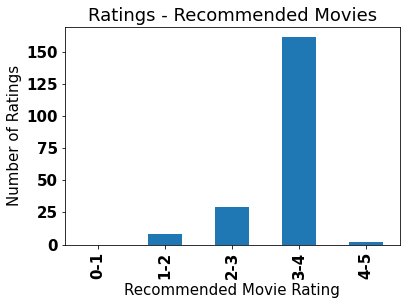

In [25]:
ranges = ['0-1', '1-2', '2-3', '3-4', '4-5']
ad = pd.DataFrame(avg_rating).melt()
ad['ratingrange'] = pd.cut(ad['value'], bins=[0,1,2,3,4,5], labels=ranges, right=True)

font = {'weight' : 'bold',
        'size'   : 15}
plt.rc('font', **font)

ax = ad.groupby(['ratingrange'])['ratingrange'].count().plot.bar()
ax.set_ylabel('Number of Ratings')
ax.set_xlabel('Recommended Movie Rating')
ax.set_title('Ratings - Recommended Movies')

# Global Diversity: Checking for the long tail
Want to recommend some "unpopular" movies such that users view movies in the long tail that they otherwise would not be exposed to
- Generate recommendations for random  users
- Merge in count of number of reviews for the recommended movies
- Take the minimum count (extent of the long tail)
- Average minimum counts across random users

In [26]:
def global_diversity(rand_user, ratings, movies_ratings, movieIds, df1, df2, keep_movies1, keep_movies2, 
                     recommendation_system, recommendation_system_input):

    length = len(rand_user)
    min_cnt = []

    # loop through random users
    for u in range(length):
        # getting recommended movies
        recommendation = recommendation_system(rand_user[u], df1, ratings, movieIds, movies_ratings, keep_movies1,
                                               df2, keep_movies2, recommendation_system_input)
        # merge with movie ratings to get number of reviews per movie
        recommendation_rating = pd.merge(recommendation, movies_ratings, on = 'movieId')

        # getting the min rating cnt of the movies recommended
        min_rating_cnt = recommendation_rating[:top_n]['cnt'].min()
        
        # keep track
        min_cnt.append(min_rating_cnt)

    # take average of minimum counts 
    avg_min_cnt = np.mean(min_cnt)
    
    return avg_min_cnt

In [27]:
random.seed(42)
# random sample of n users 
rand_user = random.sample(list_user, n)  

avg_min_cnt = global_diversity(rand_user, ratings, movies_ratings, movieIds, df1, df2, keep_movies1, keep_movies2, 
                               recommendation_system, recommendation_system_input)

print(f"Average of the minimum count of ratings for {n} user's top {top_n} recommendations (long tail):{np.round(avg_min_cnt,2)}",
      file = f)

## Close File

In [28]:
f.close()